In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!pip install tensorflow-gpu==2.3.0rc0 tensorflow_probability

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras

tfd = tfp.distributions
tfb = tfp.bijectors

print('tensorflow: ', tf.__version__)
print('tensorflow-probability: ', tfp.__version__)

tensorflow:  2.3.0
tensorflow-probability:  0.11.0


In [4]:
#GPU check
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**LOAD DATA**

In [3]:
from keras.preprocessing.image import ImageDataGenerator
#dataset = 'cifar10'

def make_iterator(flow):
    def itertor():
        return flow.next()

    return itertor


def get_data(dataset, batch_size):
    if dataset == "mnist":
        from keras.datasets import mnist

        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        y_train = y_train.reshape([-1])
        y_test = y_test.reshape([-1])

        x_train = np.lib.pad(x_train, ((0, 0), (2, 2), (2, 2)), 'minimum')
        x_test = np.lib.pad(x_test, ((0, 0), (2, 2), (2, 2)), 'minimum')

        x_train = np.tile(np.reshape(x_train, (-1, 32, 32, 1)), (1, 1, 1, 3))
        x_test = np.tile(np.reshape(x_test, (-1, 32, 32, 1)), (1, 1, 1, 3))

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')

        x_train = (x_train /(255.0/2)) - 1
        x_test = (x_test /(255.0/2)) - 1

    elif dataset == "cifar10":
        (train_x, train_y), (test_x, test_y) = keras.datasets.cifar10.load_data()
        x_train = tf.cast(train_x, dtype=tf.float32)
        x_test = tf.cast(test_x, dtype=tf.float32)
        x_train = (train_x / (255.0 / 2)) - 1
        x_test = (test_x /(255.0/2)) - 1
        y_train = train_y.reshape([-1])
        y_test = test_y.reshape([-1])

    datagen_test = ImageDataGenerator()
    datagen_train = ImageDataGenerator(width_shift_range=0.1,
                                       height_shift_range=0.1)

    datagen_train.fit(x_train)
    datagen_test.fit(x_test)

    train_flow = datagen_train.flow(x_train, y_train, batch_size)
    test_flow = datagen_test.flow(x_test, y_test, batch_size, shuffle=True)

    train_iterator = make_iterator(train_flow)
    test_iterator = make_iterator(test_flow)

    return train_iterator, test_iterator

def get_data_alt(batch_shuffle_size, batch_size):
    from keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    @tf.function
    def _parse_function(img, label):
        feature = {}
        img = tf.pad(img, paddings=[[2, 2], [2, 2]], mode="CONSTANT")
        img = tf.expand_dims(img, axis=-1)
        img = tf.reshape(img, [32, 32, 1])
        # print(img.shape)
        img = tf.tile(img, ( 1, 1, 3))

        img = tf.cast(img, dtype=tf.float32)
        img = (img / (255.0 / 2)) - 1
        # img = img/255.0
        feature["img"] = img
        feature["label"] = label
        return feature


    train_dataset_raw = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(
            _parse_function
            )
    test_dataset_raw = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(
            _parse_function
            )
    train_dataset = train_dataset_raw.shuffle(batch_shuffle_size).batch(batch_size)
    test_dataset = test_dataset_raw.shuffle(batch_shuffle_size).batch(batch_size)

    return train_dataset, test_dataset

**MODEL LAYERS**

In [4]:
#Activation Normalization layer
class ACT(tfp.bijectors.Bijector):

    # Ref - https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Bijector
    def __init__(self, channels, validate_args=False, name='actnorm', log_scale_factor = 1.0):
        super(ACT, self).__init__(
          validate_args=validate_args,
          forward_min_event_ndims=1,
          name=name)
        self.log_scale_factor = log_scale_factor
        self.initialized = False
        self.log_scale = tf.Variable( tf.random.normal([channels]), name=name + "/logScale")
        self.bias = tf.Variable(tf.random.normal([channels]),name=name + "/bias")

    def actnorm_mean_var(self, x):
        mean = tf.math.reduce_mean(x, axis=[0, 1, 2])
        var = tf.math.reduce_mean((x-mean) ** 2, axis=[0, 1, 2])
        stdVar = tf.math.sqrt(var) + 1e-6
        log_scale = tf.math.log(1./ stdVar / self.log_scale_factor) * self.log_scale_factor
        # print('log scale shape: ', log_scale.shape)
        self.bias.assign(-mean)
        self.log_scale.assign(log_scale)

    def _forward(self, x):
        if not self.initialized:
            self.actnorm_mean_var(x)
            self.initialized = True
        return (x + self.bias) * tf.exp(self.log_scale)

    def _inverse(self, y):
        if not self.initialized:
            self.actnorm_mean_var(y)
            self.initialized = True
        return y * tf.exp(-self.log_scale) - self.bias

    ### Formula the same as in paper but this is producing values like -1825236.9 something
    ### for log_det_jcb which seems like a pretty huge value for the below test values. 
    def _forward_log_det_jacobian(self, x):
        shape = x.get_shape()
        # log_det = int(shape[1]) * int(shape[2])
        # print(log_det)
        # return log_det * tf.reduce_sum(self.log_scale)
        return tf.reduce_sum(self.log_scale)

    def _inverse_log_det_jacobian(self, y):
        # shape = y.get_shape()
        # log_det = int(shape[1]) * int(shape[2])
        # return - log_det * tf.reduce_sum(self.log_scale)
        # print(self.log_scale)
        # print(tf.reduce_sum(self.log_scale))
        #print('Test inverse value: ', tf.reduce_sum(self.log_scale))
        return -tf.reduce_sum(self.log_scale)

def test_actnorm():
    actnorm = ACT(4)
    x = tf.random.normal([100, 16, 16, 4]) + 100
    y = actnorm.forward(x)
    z = actnorm.inverse(y)
    print('input: x', tf.reduce_mean(x, axis=[0, 1, 2]).numpy())
    print('output: y', tf.reduce_mean(y, axis=[0, 1, 2]).numpy())
    print('inverse: z', tf.reduce_mean(z, axis=[0, 1, 2]).numpy())
    print('log_det_jacobian: ', actnorm.forward_log_det_jacobian(y, event_ndims=3).numpy()/256) ## this prints very large values
    print('log_det_jacobian: ', actnorm.inverse_log_det_jacobian(y, event_ndims=3).numpy()/256)
    print(tf.shape(y))
    print(tf.size(tf.shape(y)))
    print('trainable variables',actnorm.trainable_variables)

# test_actnorm()

In [5]:
#Affine Coupling layer
class NN(keras.layers.Layer):
    def __init__(self,
            output_shape,
            activation="relu",
            kernel_size = [[3,3], [1,1]],
            n_hidden=[512,512], 
            stride = [1,1],
            padding="SAME",
            name="nn"):
        if name:
            super(NN,self).__init__(name=name)
        else:
            super(NN,self).__init__()

        ### official implementation uses different initialisation for weights for the first 2 layers.
        ### random_normal_initialiser. ours is Xavier. 
        ### We are using Xavier because the paper doesn't talk about their initialisation method benefits as such 
        # and Xavier is used in most of the networks. However, we dont know the significance of this difference.
        self.conv1 = keras.layers.Conv2D(n_hidden[0], kernel_size = kernel_size[0], strides=stride, padding=padding, activation=activation, name=name+"/conv_1")
        self.conv2 = keras.layers.Conv2D(n_hidden[1], kernel_size = kernel_size[1], strides=stride, padding=padding, activation=activation, name=name+"/conv_2")
        self.log_s_layer = keras.layers.Conv2D(output_shape, kernel_size=[3,3], strides = stride,  kernel_initializer="zeros", padding=padding, activation='tanh', name=name+"/conv_log_s")
        self.t_layer = keras.layers.Conv2D(output_shape, kernel_size=[3,3], strides = stride,  kernel_initializer="zeros", padding=padding, name=name+"/conv_t")
        # self.conv3 = keras.layers.Conv2D(output_shape, kernel_size=[3,3], strides = stride, padding=padding, name=name+"/conv_3")

    def call(self,x):
        # print("weights: ", self.conv1.weights)
        # print("conv1 input: ", x.shape)
        x = self.conv1(x)
        # print("conv2 input: ", x.shape)
        x = self.conv2(x)
        # print("conv3 input: ", x.shape)
        log_s = self.log_s_layer(x)
        t = self.t_layer(x)
        # print("output: ", x.shape)
        return log_s, t


class ACL(tfp.bijectors.Bijector):
    def __init__(self, output_shape, 
            forward_min_event_ndims = 3, 
            validate_args=False,
            name="acl",
            **kwargs):

        super(ACL, self).__init__(
            validate_args=validate_args,
            forward_min_event_ndims=forward_min_event_ndims,
            name=name)

        self.output_shape = output_shape
        self.nn_obj = NN(self.output_shape[-1]//2, name=name+"/NN", **kwargs)
        k_inp = self.output_shape.copy()
        k_inp[-1] = self.output_shape[-1] // 2
        
        x = tf.keras.Input(k_inp)
        # print("keras input: ", x.shape)
        log_s, t = self.nn_obj(x)
        self.nn = tf.keras.Model(x, [log_s, t], name=self.name + "/nn")
        
    def _forward(self, x):
        # print()
        x_a, x_b = tf.split(x, 2, axis = -1)
        y_b = x_b
        log_s, t = self.nn(x_b)
        # h = self.nn(x_b)
        # t = h[:,:,:,0::2]
        # scale = keras.activations.sigmoid(h[:,:,:,1::2] + 2.)
        # log_s = keras.activations.tanh(h[:,:,:,1::2])
        scale = tf.exp(log_s)
        y_a = scale * x_a + t
        y = tf.concat([y_a,y_b], axis=-1)
        return y

    def _inverse(self, y):
        y_a, y_b = tf.split(y, 2, axis = -1)
        # print('This is y_b shape : ', y_b.shape)
        # h = self.nn(y_b)
        # t = h[:,:,:,0::2]
        log_s, t = self.nn(y_b)
        # scale = keras.activations.sigmoid(h[:,:,:,1::2] + 2.)
        # log_s = keras.activations.tanh(h[:,:,:,1::2])
        scale = tf.exp(log_s)
        x_a = (y_a - t)/scale
        x_b = y_b
        x = tf.concat([x_a, x_b], axis = -1)
        return x

    def _forward_log_det_jacobian(self, x):
        _ , x_b = tf.split(x, 2, axis = -1)
        log_s, _ = self.nn(x_b)
        # h = self.nn(x_b)
        # log_s = keras.activations.tanh(h[:,:,:,1::2])
        scale = tf.math.exp(log_s)
        # scale = keras.activations.sigmoid(h[:,:,:,1::2] + 2.)
        # log_s = tf.math.log(scale)

        # print("log scale values", scale)
        # print("test: ", K.eval(tf.reduce_sum(log_s, axis = [1,2,3])))
        return tf.reduce_sum(log_s)


def nn_test():
    nn = NN(4, name="NN")
    x = tf.random.normal([3, 32, 32, 4])
    x = tf.keras.Input([32,32,2])
    print(x.shape)
    log_s = nn(x)
    print(log_s)
    # Non trainable params: -> Batch Normalization's params
    tf.keras.Model(x, [log_s], name="nn_test").summary()

# nn_test()

def realnvp_test():
    realnvp = ACL(output_shape=[16, 16, 4], n_hidden=[256, 256])
    x = tf.keras.Input([16, 16, 4])

    y = realnvp.forward(x)
    print("trainable_variables :", len(realnvp.trainable_variables))
    print('trainable variable NN: ', len(realnvp.nn.trainable_variables))
    
    flow = tfd.TransformedDistribution(
        event_shape=[16, 16, 4],
        distribution=tfd.Normal(loc=0.0, scale=1.0),
        bijector=realnvp,
    )
    x = flow.sample(5)
    print(x.shape)
    # y = realnvp.inverse(x)
    log_prob = flow.log_prob(y)
    print(realnvp.inverse_log_det_jacobian(x, event_ndims=3).numpy() )
    print(
        x.shape,
        # y.shape,
        log_prob,
        # -tf.reduce_mean(log_prob),
        # -tf.reduce_mean(flow.distribution.log_prob(x)),
        # -tf.reduce_mean(
        #     flow.bijector.forward_log_det_jacobian(
        #         x, event_ndims=flow._maybe_get_static_event_ndims()
        #     )
        # ),
        # -tf.reduce_mean(flow._log_prob(x)),
        # flow._finish_log_prob_for_one_fiber(
        #     y,
        #     x,
        #     flow.bijector.forward_log_det_jacobian(
        #         x, event_ndims=flow._maybe_get_static_event_ndims()
        #     ),
        #     flow._maybe_get_static_event_ndims(),
        #
        # ),
        # tf.reduce_sum(flow.distribution.log_prob(
        #     flow._maybe_rotate_dims(x, rotate_right=True)),
        #               axis=flow._reduce_event_indices)
    )

#realnvp_test()

In [6]:
#Blockwise module
class Blockwise(tfb.Bijector):
    def __init__(self,
                 bijectors : list,
                 block_sizes : list = None,
                 validate_args=False,
                 name="blockwise"):
        super(Blockwise, self).__init__(
            forward_min_event_ndims = 3,
            validate_args=validate_args,
            name=name
        )
        self._bijectors = bijectors
        self._block_sizes = block_sizes

    @property
    def bijectors(self):
        return self._bijectors

    @property
    def block_sizes(self):
        return self._block_sizes

    def _forward(self, x):
        split_x = (tf.split(x, len(self.bijectors), axis=-1)
                   if self.block_sizes is None 
                   else tf.split(x, self.block_sizes, axis=-1))
        split_y = [b.forward(x_) for b, x_ in zip(self.bijectors, split_x)]
        y = tf.concat(split_y, axis=-1)
        return y

    def _inverse(self, y):
        split_y = (tf.split(y, len(self.bijectors), axis=-1)
                   if self.block_sizes is None 
                   else tf.split(y, self.block_sizes, axis=-1))
        split_x = [b.inverse(y_) for b, y_ in zip(self.bijectors, split_y)]
        x = tf.concat(split_x, axis=-1)
        return x

    def _forward_log_det_jacobian(self, x):
        split_x = (tf.split(x, len(self.bijectors), axis=-1)
                   if self.block_sizes is None
                   else tf.split(x, self.block_sizes, axis=-1))
        fldjs = [
            b.forward_log_det_jacobian(x_, event_ndims=3)
            for b, x_ in zip(self.bijectors, split_x)
        ]
        return sum(fldjs)

    def _inverse_log_det_jacobian(self, y):
        split_y = (tf.split(y, len(self.bijectors), axis=-1)
                   if self.block_sizes is None
                   else tf.split(y, self.block_sizes, axis=-1))
        ildjs = [
            b.inverse_log_det_jacobian(y_, event_ndims=3)
            for b, y_ in zip(self.bijectors, split_y)
        ]
        return sum(ildjs)


In [7]:
#Inverse 1*1 Convolution
def invertible_1x1_conv_LU(event_size, batch_shape=(), seed=None, dtype=tf.float32, name="lu_inv_conv"):

    with tf.name_scope(name or 'trainable_lu_factorisation'):
        event_size = tf.convert_to_tensor(
                        event_size, dtype=tf.int32, name='event_size')
        batch_shape = tf.convert_to_tensor(
                        batch_shape, dtype=event_size.dtype, name='batch_shape')
        random_matrix = tf.Variable(tf.random.uniform(
                        shape=tf.concat([batch_shape, [event_size, event_size]], axis=0),
                        dtype=dtype,
                        seed=seed),
                        name='1x1_inv_conv_weights')
        #QR decomposition gives us 2 matrix
        # 0 index - orthogonal matrix which has orthornormal unit vector columns
        # 1 index Right upper triangular matrix.
        random_orthornormal = tf.linalg.qr(random_matrix).q

        # we do LU decomposition of orthogonal matrix 
        # 0th index gives lower_upper triangular matrix
        # 1 index give permutation matrix.
        #lower_upper, permutation = tf.linalg.lu(random_orthornormal)

        lower_upper = tf.Variable(tf.linalg.lu(random_orthornormal)[0], trainable=True, name='lower_upper')
        permutation = tf.Variable(tf.linalg.lu(random_orthornormal)[1], trainable=False, name='permutation')

        # lower_upper = tf.Variable(
        #                 initial_value=lower_upper,
        #                 trainable = True,
        #                 name='lower_upper')
        # permutation = tf.Variable(
        #                 initial_value=permutation,
        #                 trainable=False,
        #                 name='permutation')
        # print("lower upper: ", lower_upper)

    # x = tf.random.uniform(shape=[2, 28, 28, 3], dtype=tf.float32)
    # print("det jacobian", inv_conv.inverse_log_det_jacobian(x,event_ndims=3)/inv_conv.inverse_log_det_jacobian(x,event_ndims=1))
    return lower_upper, permutation

def build_model(channels=3):
    # conv1x1 setup
    # t_lower_upper, t_permutation = invertible_1x1_conv_LU(channels)
    lower_upper, permutation = invertible_1x1_conv_LU(channels)
    inv_conv = tfb.MatvecLU(lower_upper, permutation, name='MatvecLU')
    # tfb.MatvecLU(t_lower_upper, t_permutation, name='MatvecLU')
    print('conv1x1 variable\n', inv_conv.variables)
    inv_conv1x1 = tfb.Invert(inv_conv)

    # forward setup
    fwd = tfp.layers.DistributionLambda(
        lambda x: inv_conv(tfd.Deterministic(x)))
    fwd.vars = inv_conv.trainable_variables

    # inverse setup
    inv = tfp.layers.DistributionLambda(
        lambda x: inv_conv1x1(tfd.Deterministic(x)))
    inv.vars = inv_conv1x1.trainable_variables
    
    x: tf.Tensor = tf.keras.Input(shape=[28, 28, channels])
    fwd_x: tfp.distributions.TransformedDistribution = fwd(x)
    rev_fwd_x: tfp.distributions.TransformedDistribution = inv(fwd_x)
    example_model = tf.keras.Model(inputs=x, outputs=rev_fwd_x, name='conv1x1')
    return example_model


def test_conv1x1():
    example_model = build_model()
    example_model.trainable = True
    example_model.summary()

    real_x = tf.random.uniform(shape=[2, 28, 28, 3], dtype=tf.float32)
    if example_model.weights == []:
        print('No Trainable Variable exists')
    else:
        print('Some Trainable Variables exist')

    with tf.GradientTape() as tape:
        tape.watch(real_x)
        out_x = example_model(real_x)
        out_x = out_x
        loss = out_x - real_x
    print(tf.math.reduce_sum(real_x - out_x))
    print(example_model.predict(real_x).shape)
    # print("log prob: ", example_model.log_prob(real_x))
    # => nealy 0
    # ex. tf.Tensor(1.3522818e-05, shape=(), dtype=float32)

    try:
        print("gradient: ",tape.gradient(loss, real_x).shape)
    except Exception as e:
        print('Cannot Calculate Gradient')
        print(e)
        
test_conv1x1()

Instructions for updating:
`MatvecLU` has been deprecated and renamed `ScaleMatvecLU`; please use that symbol instead.
conv1x1 variable
 (<tf.Variable 'lu_inv_conv/lower_upper:0' shape=(3, 3) dtype=float32, numpy=
array([[-0.7793306 ,  0.6101671 , -0.14261748],
       [ 0.5125994 , -0.9719273 , -0.5640173 ],
       [ 0.6194529 ,  0.8411388 ,  1.3202144 ]], dtype=float32)>, <tf.Variable 'lu_inv_conv/permutation:0' shape=(3,) dtype=int32, numpy=array([0, 1, 2], dtype=int32)>)
Model: "conv1x1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
distribution_lambda (Distrib ((None, 28, 28, 3), (None 12        
_________________________________________________________________
distribution_lambda_1 (Distr ((None, 28, 28, 3), (None 12        
Total params: 12
Trainable params: 9
Non-t

In [8]:
#Squeeze layer
class Squeeze(tfb.Bijector):
    def __init__(self, factor=2, name='squeeze', forward_min_event_ndims=0, inverse_min_event_ndims=0, validate_args=False):
        self._factor = factor
        #self.name = name
        super(Squeeze, self).__init__(name=name, is_constant_jacobian = True,
                                      forward_min_event_ndims=forward_min_event_ndims,
                                      inverse_min_event_ndims=inverse_min_event_ndims)
        
    @property
    def factor(self):
        return self._factor

    def _forward(self, x):
        (h,w,c) = x.shape[1:]
        batch_size = tf.shape(x)[0:1]
        temp_shape = tf.concat([batch_size, 
                                (h//self.factor, self.factor, w//self.factor, self.factor, c),
                                ], axis=0)
        output_shape = tf.concat([batch_size, 
                                (h//self.factor, w//self.factor, c*self.factor*self.factor),
                                ], axis=0)
        transpose_permutation = [0, 1, 3, 5, 2, 4]
        y = tf.reshape(x, temp_shape)
        y = tf.transpose(y, transpose_permutation)
        y = tf.reshape(y, output_shape)
        return y

    def _inverse(self, y):
        (h,w,c) = y.shape[1:]
        batch_size = tf.shape(y)[0:1]
        # temp_shape = (batch_size, h, w, c//(self.factor*self.factor), self.factor, self.factor)
        temp_shape = tf.concat([batch_size, 
                                (h, w, c//(self.factor*self.factor), self.factor, self.factor),
                                ], axis=0)
        output_shape = tf.concat([batch_size, 
                                (h*self.factor, w*self.factor, c//(self.factor*self.factor)),
                                ], axis=0)
        transpose_permutation = [0, 1, 4, 2, 5, 3]
        x = tf.reshape(y, temp_shape)
        x = tf.transpose(x, transpose_permutation)
        x = tf.reshape(x, output_shape)
        return x

    def _forward_log_det_jacobian(self, x):
        return tf.constant(0.0)
    
    # def _inverse_log_det_jacobian(self, x, event_ndims=0):
    #     return tf.constant(0.0)

def test_squeeze():
    factor = 2
    x = tf.Variable([[[1, 2, 5, 6], [3, 4, 7, 8], [9, 10, 13, 14],
                      [11, 12, 15, 16]]])
    x = tf.expand_dims(x, axis=-1)
    squeeze = Squeeze(factor=factor)
    y = squeeze.forward(x)
    z = squeeze.inverse(y)
    print(tf.reduce_sum(x - z))

    flow = tfd.TransformedDistribution(event_shape=[16, 16, 2],
                                       distribution=tfd.Normal(loc=0.,
                                                               scale=1.),
                                       bijector=squeeze)
    x = tf.random.normal([64, 16, 16, 2])
    y = flow.bijector.forward(x)
    log_prob = flow.log_prob(y)
    print(x.shape, y.shape, log_prob.shape)
    print(squeeze._forward_log_det_jacobian(x))
    
#test_squeeze()


In [9]:
def gen_flowSteps(
    # for realnvp
    input_shape: list,
    n_hidden: list = [128, 128],
    # for flowStep
    k=4,
    forward_min_event_ndims: int = 3,
    validate_args: bool = False,
    name: str = "flow_step",
):
    flow_step_list = []
    for i in range(k):
        t_lower_upper, t_permutation = invertible_1x1_conv_LU(input_shape[-1])
        flow_step_list.append(ACT(input_shape[-1]))
        flow_step_list.append(
            tfb.MatvecLU(
                t_lower_upper, t_permutation, name="{}_{}/matveclu".format(name, i)
            )
        ),
        flow_step_list.append(
            ACL(
                output_shape=input_shape,
                n_hidden=n_hidden,
                validate_args=validate_args,
                name="{}_{}/acl".format(name, i),
            )
        )

    flowSteps = tfb.Chain(
        list(reversed(flow_step_list)), validate_args=validate_args, name=name
    )
    return flowSteps


def test_gen_flowSteps():
    flowSteps = gen_flowSteps(
        k=2, input_shape=[16, 16, 4], forward_min_event_ndims=0, name="flowstep_0"
    )
    x = tf.keras.Input([16, 16, 4])
    y = flowSteps(x)
    # tf.keras.Model(x, y).summary()

    x = tf.random.normal([6, 16, 16, 4])
    y = flowSteps.forward(x)
    z = flowSteps.inverse(y)
    return tf.reduce_sum(z - x)


#test_gen_flowSteps()

In [10]:
def gen_flow(input_shape, level=3, flow_step_args: dict = None):
    def _gen_input_shapes(input_shape, level):
        input_shape = input_shape
        input_shapes = []
        for i in range(level):
            input_shape = [
                input_shape[0] // 2,
                input_shape[1] // 2,
                input_shape[2] * 2,
            ]
            input_shapes.append(input_shape)
        return input_shapes

    input_shape[-1] = input_shape[-1] * 2
    input_shapes = _gen_input_shapes(input_shape, level)

    def _add_flow(_input_shapes, flow_step_args):
        flow_lists = []
        flow_lists.append(
            Squeeze(name="Squeeze_{}".format(level - len(_input_shapes)))
        )
        flowSteps = gen_flowSteps(
           k=2,
           input_shape=_input_shapes[0],
           name="Flowsteps_{}".format(level - len(_input_shapes)),
        )
        flow_lists.append(flowSteps)
        if len(_input_shapes) != 1:
            flow_lists.append(
                Blockwise(
                    [
                        tfb.Identity(),
                        tfb.Chain(
                            list(reversed(_add_flow(_input_shapes[1:], flow_step_args)))
                        ),
                    ],
                    name="Blockwise3D_{}".format(level - len(_input_shapes)),
                )
            )
        flow_lists.append(
            tfb.Invert(
                Squeeze(name="Unsqueeze_{}".format(level - len(_input_shapes)))
            )
        )
        return flow_lists

    return tfb.Chain(list(reversed(_add_flow(input_shapes, level))))


def test_gen_flow():
    flow = gen_flow([32, 32, 1])
    print(len(flow.trainable_variables))
    x = tf.keras.Input([32, 32, 1])
    y = flow.forward(x)
    # tf.keras.Model(x, y).summary()
    tf.keras.utils.plot_model(
        tf.keras.Model(x, y), show_shapes=True, to_file="realnvp.png"
    )
    x = tf.random.normal([3, 32, 32, 1])
    y = flow.forward(x)
    z = flow.inverse(y) 
    return tf.reduce_sum(z - x)

test_gen_flow()

66


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

**Build Model**

In [ ]:
# class Flow(tfb.Bijector):
#     def __init__(self, L,
#         K,
#         activation,
#         input_shape,
#         num_of_hidden,
#         name="flow_model"
#     ):

#         super(Flow, self).__init__(
#             validate_args=False,
#             forward_min_event_ndims=0,
#             name=name)
        
#         self.L = L
#         self.K = K
#         self.input_shapes = self._get_input_shapes(input_shape, L)

#         #print(self.input_shapes)
#         self.flow_network = tfb.Chain(list(reversed(self.add_flow(self.input_shapes, name=name+"/Flow_0"))))

#     def add_flow(self, input_shape, name):
#         flow_layers = []
#         squeeze_layer = Squeeze(2, name=name+"/squeeze_{}".format(self.L - len(input_shape)))
#         flow_layers.append(squeeze_layer)
#         flow_steps = self._flow_steps(self.K, input_shape=input_shape[0], name=name+"/flow_step_{}".format(self.L - len(input_shape)))
#         flow_layers.append(flow_steps)
#         if len(input_shape) != 1:
#             #Blockwise
#             blockwise_mod = Blockwise(bijectors=[tfb.Identity(), tfb.Chain(
#                             list(reversed(self.add_flow(input_shape[1:], name = name.split('_')[0]+"_{}".format(self.L-len(input_shape[1:])))))
#                         )], name=name+"/blockwise_{}".format(self.L - len(input_shape)))
#             flow_layers.append(blockwise_mod)
#         squeeze_invert = tfb.Invert(Squeeze(2, name=name+"/unsqueeze_{}".format(self.L - len(input_shape))))
#         flow_layers.append(squeeze_invert)
#         return flow_layers
    
#     def _flow_steps(self, K, input_shape, name):
#         flow_steps_list = []
#         for i in range(K):
#             act_norm = ACT(input_shape[-1], False, name=name+"/actnorm_{}".format(i))
#             inv_conv = invertible_1x1_conv_LU(input_shape[-1], name=name+"/inv_conv_1x1_{}".format(i))
#             acl = ACL(input_shape, name=name+"/acl_{}".format(i))
            
#             flow_steps_list.append(act_norm)
#             flow_steps_list.append(inv_conv)
#             flow_steps_list.append(acl)

#         flow_steps = tfb.Chain(list(reversed(flow_steps_list)), validate_args=False, name=name)
#         return flow_steps
    
#     def _get_input_shapes(self, input_shape, level):
#         # print(level)
#         input_shapes = []
#         for i in range(level):
#             input_shape = [input_shape[0]//2,
#                             input_shape[1]//2,
#                             (input_shape[2] * 4) - (i * 24)]
#             input_shapes.append(input_shape)

#         return input_shapes
#     # model paramters
    
# class Glow_Model(tf.keras.Model):
#     def __init__(self, name):
#         L=3
#         K=32
#         activation = "relu"
#         input_shape = [32,32,3]
#         num_of_hidden = [512,512]
#         name="glow_model"
#         print("inside glow model init")
#         super(Glow_Model, self).__init__( name)

#         self.flow_model = Flow(L, K, activation, input_shape, num_of_hidden, name=name+"/flow_bijector")

#         self.flow_distribution_obj = tfd.TransformedDistribution(
#                                 event_shape=input_shape,
#                                 distribution=tfd.Normal(loc=0.0, scale=1.0),
#                                 bijector=self.flow_model                        
#                             )
        
#     def call(self, inputs):
#         return self.flow_distribution_obj.bijector.forward(inputs)

#     def log_prob(self, inputs):
#         return self.flow_distribution_obj.log_prob(inputs)
    
#     def getFlowSample(self, num):
#         return self.flow_distribution_obj.sample(num)

In [11]:
flow_bijector = gen_flow([32, 32, 3], level=3)
print(len(flow_bijector.trainable_variables))
flow = tfd.TransformedDistribution(
    event_shape =[32, 32, 3],
    distribution=tfd.Normal(loc=0.0, scale=1.0),
    bijector=flow_bijector
)
print('trainable_variables: ', len(flow.bijector.trainable_variables))

66
trainable_variables:  66


**Training**

[Flow] Latest checkpoint restored!!
Epoch 0 Step 77400 Loss 705.638855
Saving checkpoint for epoch 1 at /content/drive/MyDrive/glow/checkpoints/checkpoint_mnist/ckpt-774
Epoch 0 Step 77500 Loss 679.874451
Saving checkpoint for epoch 1 at /content/drive/MyDrive/glow/checkpoints/checkpoint_mnist/ckpt-775
Epoch 0 Step 77600 Loss 658.481323
Saving checkpoint for epoch 1 at /content/drive/MyDrive/glow/checkpoints/checkpoint_mnist/ckpt-776
Epoch 0 Step 77700 Loss 637.424011
Saving checkpoint for epoch 1 at /content/drive/MyDrive/glow/checkpoints/checkpoint_mnist/ckpt-777
Epoch 1 Step 77800 Loss 617.304504
Saving checkpoint for epoch 2 at /content/drive/MyDrive/glow/checkpoints/checkpoint_mnist/ckpt-778
Epoch 1 Step 77900 Loss 601.019348
Saving checkpoint for epoch 2 at /content/drive/MyDrive/glow/checkpoints/checkpoint_mnist/ckpt-779
Epoch 1 Step 78000 Loss 586.898682
Saving checkpoint for epoch 2 at /content/drive/MyDrive/glow/checkpoints/checkpoint_mnist/ckpt-780
Epoch 1 Step 78100 Loss 57

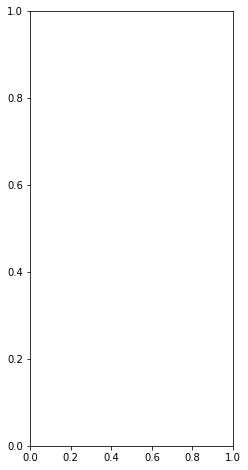

In [41]:
from pathlib import Path
from tqdm import tqdm
from keras import backend as KB

L=3
K=32
epochs = 50
learning_rate = 1e-4
BATCH_SIZE=128
input_shape = [32,32,3]

bpd_factor = np.log(2) * input_shape[0] * input_shape[1] * input_shape[2]

# glow_model = Glow_Model(name="glow_model")
# glow_model.build((1,32,32,3))
# print(glow_model.summary())
#flow = Flow(L, K, "relu", [32,32,3], [512,512], name="test")
#flow_distribution = tfd.TransformedDistribution(
#                            event_shape=input_shape,
#                            distribution=tfd.Normal(loc=0.0, scale=1.0),
#                            bijector=flow.flow_network                       
#                        )
# x = tf.random.normal([3, 32, 32, 3])
# y = flow_distribution.bijector.forward(x)
# z = flow_distribution.bijector.inverse(y)
fig = plt.figure(figsize=(8,8))
fig.add_subplot(1,2,1)
# plt.imshow(x[0])
# # plt.show()
# fig.add_subplot(1,2,2)
# plt.imshow(z[0])
# # plt.show()
# print(tf.reduce_sum(z-x))
# print(flow_distribution.log_prob(x).shape)

# @tf.function
def loss():
    #x_ = np.clip(np.floor(x), 0, 255) /255.0
    #print(x.shape)
    # x_ = (np.clip(np.floor(x), 0, 255)/(255.0/2.0)) - 1
    #x_.astype(np.float32)
    # print("input x: ", np.around(x_[0], 3))
    #plt.imshow(x[0])
    #plt.show()
    # print(np.max(x_[0,:,:,:]))
    # print("bpd factor: ", bpd_factor, x_.shape)
    log_det = - tf.reduce_mean(flow.log_prob(x))
    #print("log det: ", log_det)
    if log_det.numpy() == np.nan:
        return log_det
    else:
        return log_det / bpd_factor
    # return tf.constant(1234)

optimizer = tf.optimizers.Adam(learning_rate=learning_rate) 
log = tf.summary.create_file_writer('checkpoints')
avg_loss = tf.keras.metrics.Mean(name='loss', dtype=tf.float32)
dataset='mnist'
# train_iterator, test_iterator = get_data(dataset, BATCH_SIZE)
train_iterator, test_iterator = get_data_alt(1000, BATCH_SIZE)
# train_its = int(60000/BATCH_SIZE)

#checkpointing 
checkpoint_path=Path('/content/drive/MyDrive/glow/checkpoints/checkpoint_mnist')
ckpt = tf.train.Checkpoint(model=flow, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,
                                            checkpoint_path,
                                            max_to_keep=3)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('[Flow] Latest checkpoint restored!!')

KB.set_value(optimizer.learning_rate, 1e-3)

flag = False

for e in range(epochs):
    if flag:
        break
    # for i in range(train_its):
    for i in train_iterator:
        x = i['img']
        # x, y = train_iterator()
        # print(x.shape)
        with tf.GradientTape() as tape:
            log_prob_loss = loss()
            # print('log prob loss : ', log_prob_loss)
        
        # for f_var in flow.trainable_variables:
        #     print('This is flow train vars : ', f_var.name)
        grads = tape.gradient(log_prob_loss, flow.trainable_variables)
        # print('This is grad value :', grads)
        # break
        optimizer.apply_gradients(zip(grads, flow.trainable_variables))
        # print("returned log prob loss: ", log_prob_loss)
        if tf.math.is_nan(log_prob_loss):
            flag = True
            print("loss is nan")
            break
        avg_loss.update_state(log_prob_loss)
        
        if tf.equal(optimizer.iterations % 100, 0):
          print("Epoch {} Step {} Loss {:.6f}".format(e, optimizer.iterations.numpy(), avg_loss.result()))

        if tf.equal(optimizer.iterations % 100, 0):
            with log.as_default():
                tf.summary.scalar("loss", avg_loss.result(), step=optimizer.iterations)
                avg_loss.reset_states()
    
            ckpt_save_path = ckpt_manager.save()
            print('Saving checkpoint for epoch {} at {}'.format(
                    e + 1, ckpt_save_path))
# print(train_iterator())

In [12]:
from pathlib import Path
checkpoint_path=Path('/content/drive/MyDrive/glow/checkpoints/checkpoint_mnist')
optimizer = tf.optimizers.Adam(learning_rate=1e-4) 
ckpt = tf.train.Checkpoint(model=flow, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,
                                            checkpoint_path,
                                            max_to_keep=10)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('[Flow] Latest checkpoint restored!!')

[Flow] Latest checkpoint restored!!


**Inference**

In [18]:
#test_dataset = test_dataset_raw.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
train_iterator, test_iterator = get_data_alt(1000, 128)

79836.34880065918
7.983634880065918
log probability:  -128.6287
inv mean:  -2.2130563  std:  10.696386
re:trg mean:  -0.7935118  std:  0.55899763


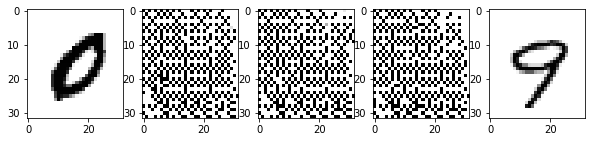

In [19]:

fig = plt.figure(figsize=(10, 2))
log_prob_nll = 0
for x_test in train_iterator:
  inv = flow.bijector.forward(x_test['img'])
  re_trg = flow.bijector.inverse(inv)
  log_prob_nll += np.abs((tf.reduce_mean(flow.log_prob(inv)) / (np.log(2.) * 32 * 32 * 3)).numpy())


print(log_prob_nll)
print(log_prob_nll/10000)
print('log probability: ', (tf.reduce_mean(flow.log_prob(inv)) / (np.log(2.) * 32 * 32 * 3)).numpy())
print("inv mean: ", tf.reduce_mean(inv).numpy(), " std: ", tf.math.reduce_std(inv).numpy())
print("re:trg mean: ", tf.reduce_mean(re_trg).numpy(), " std: ", tf.math.reduce_std(re_trg).numpy())

def  interporate(a, b, percent):
  re_inv = np.array([(percent * a +  (1 - percent) * b)])
  re_re_inv = flow.bijector.inverse(re_inv)
  out_val = tf.nn.relu6(re_re_inv - tf.reduce_mean(re_re_inv))
  #out_norm = (out_val - np.min(out_val)) / (np.max(out_val) - np.min(out_val))
  return out_val
# re_inv = np.array([(inv[0] + inv[1]) / 2.0])
# print(re_inv.shape)
#print(tf.reduce_mean(re_inv))
# re_re_trg = flow.bijector.inverse(re_inv)

re_trg = re_trg.numpy()

re_trg = (re_trg + 1) * 127.5
re_trg = re_trg.astype(np.uint8)

# test_value = interporate(inv[0], inv[1], 0.75)
# print(np.min(test_value), np.max(test_value))

# test_val = np.random.randn(32,32,3)


ax = fig.add_subplot(1, 5, 1)
ax.imshow(re_trg[0,:,:,0], aspect="auto", cmap="gray_r")

ax = fig.add_subplot(1, 5, 2)
ax.imshow(interporate(inv[0], inv[1], 0.75)[0,:,:,0], aspect="auto", cmap="gray_r")

ax = fig.add_subplot(1, 5, 3)
ax.imshow(interporate(inv[0], inv[1], 0.5)[0,:,:,0], aspect="auto", cmap="gray_r")

ax = fig.add_subplot(1, 5, 4)
ax.imshow(interporate(inv[0], inv[1], 0.25)[0,:,:,0], aspect="auto", cmap="gray_r")

ax = fig.add_subplot(1, 5, 5)
ax.imshow(re_trg[1,:,:,0], aspect="auto", cmap="gray_r")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


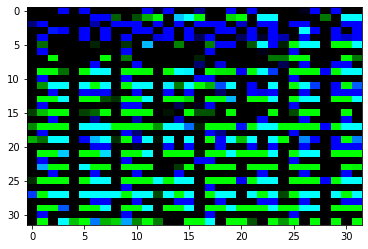

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


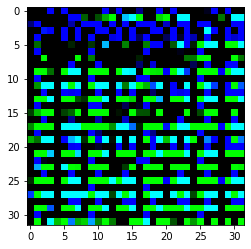

In [29]:
abc = tfp.distributions.Sample(flow)
x = abc.sample()
x_1 = flow.bijector.forward(tf.reshape(x, (1, 32, 32 ,3)))
#print(x)
plt.imshow(x, aspect="auto", cmap="gray_r")
plt.show()
efg = flow.bijector.inverse(x_1)
plt.imshow(efg[0])